### Utility file
Various functions to process the initial bed data

In [159]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from motif_utils import seq2kmer

#### Preparing the .bed file list

In [160]:
# file name reader
# make a list of all the filename

path='../database/bed/unzipped/'
bed_files=os.listdir(path)

def file_list_maker(path, files):
    all_files=[]
    for file in files:
        file_path=os.path.join(path,file)
        all_files.append(file_path)
    return all_files
all_files=file_list_maker(path, bed_files)

In [161]:
all_files[0]

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [162]:
# test file
test_filename='../database/bed/unzipped/E017_15_coreMarks_stateno.bed'

In [163]:
state_dict={1:"A", 2:"B", 3:"C", 4:"D", 5:"E",6:"F",7:"G",8:"H" ,
                9:"I" ,10:"J",11:"K", 12:"L", 13:"M", 14:"N", 15:"O"}

In [287]:
css_name=['TssA','TssAFlnk','TxFlnk','Tx','TxWk','EnhG','Enh','ZNF/Rpts',
          'Het','TssBiv','BivFlnk','EnhBiv','ReprPC','ReprPcWk','Quies']

In [305]:
css_dict=dict(zip(list(state_dict.values()), css_name))  # css_dict={"A":"TssA", "B":"TssAFlnk", ... }

In [306]:
css_color_dict={'TssA':(219, 57, 50), 'TssAFlnk': (222, 87, 54), 'TxFlnk': (107, 187, 87),
                'Tx': (57, 124, 72), 'TxWk': (48, 98, 58), 'EnhG': (197, 213, 80), 'Enh': (245, 196, 98),
                'ZNF/Rpts': (129, 194, 169), 'Het': (137,143,189), 'TssBiv': (192, 98, 95), 
                'BivFlnk': (223, 156, 127), 'EnhBiv': (188, 182, 115), 'ReprPC': (147, 149, 153),
                'ReprPCWk': (200, 202, 203), 'Quies': (255, 255, 255)}

#### Function to convert RGB into decimal RGB

In [337]:
def colors2color_dec(css_color_dict):
    colors=list(css_color_dict.values())
    color_dec_list=[]
    for color in colors:
        color_dec=tuple(rgb_elm/255 for rgb_elm in color)
        color_dec_list.append(color_dec)        
    return color_dec_list

#### Functions to make .bed to dataframe

In [164]:
# create dataframe from bed file
# bed file here means: EXXX_15_coreMarks_stateno.bed

def bed2df_as_is(filename):    
    
    """Create dataframe from the .bed file, as is.
    Dataframe contains following columns:
    chromosome |  start |  end  | state """
    
    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    
    return df

In [165]:
def bed2df_expanded(filename):
    
    """Create an expanded dataframe from the .bed file.
    Dataframe contains following columns:
    chromosome |  start |  end  | state | length | unit | state_seq | state_seq_full"""
   
    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    df["state"]=pd.to_numeric(df["state"])
    df["length"]=df["end"]-df["start"]
    df["unit"]=(df["length"]/100).astype(int)
               
    df["state_seq"]=df["state"].map(state_dict)
    df["state_seq_full"]=df["unit"]*df["state_seq"]
    
    return df 

In [166]:
def total_df_maker(all_files):
    
    """Create a list of dataframe from a list of bed files.]
    This function utilizes the function named 'bed2df_expanded.'"""
    
    total_df=[]
    for filename in all_files:
        df=bed2df_expanded(filename)
        total_df.append(df)
    return total_df

#### Functions for analyzing an individual dataframe

CSS here refers Chromatin state sequence

In [167]:
def numchr(df):
    assert "chromosome" in df.columns, "Check your df has the column named 'chromosome'"
    return df["chromosome"].nunique()    

In [168]:
# create a large piece of string of the whole state_seq_full 
# CSS: chromatin-state sequence

def df2css_allchr(df):
    
    """Create a large piece of string of the whole state_seq_full 
    This function generates a string from the entire chromosomes"""
    
    state_seq_full_list=df["state_seq_full"].tolist()
    state_seq_full_to_str=''.join([elm for elm in state_seq_full_list ])
    return state_seq_full_to_str

#### Create CSS chromosome-wise

In [169]:
# first, learn where one chromosome ends in the df
# this is just a prerequisite function for df2css_chr

def df2chr_index(df):
    
    """Create a list of smaller piece of string of the state_seq_full per chromosome
    This function generates a list of chromatin state sequence strings chromosome-wise"""
    
    total_row=len(df)
    chr_len=[]
    chr_check=[]
    chr_index=[]

    for i in range(total_row):
        if (df["start"].iloc[i]==0) & (i >0):
            chr_len.append(df["end"].iloc[i-1]) # chr_len stores the end position of each chromosome
            chr_check.append(df["start"].iloc[i]) # for assertion : later check chr_check are all zero
            chr_index.append(i-1) # the index (row number)

    end_len=df["end"].iloc[-1] # add the final end position
    end_index=total_row-1 # add the final end index (row number)
 
    chr_len.append(end_len)
    chr_index.append(end_index)

    assert len(chr_len)==df["chromosome"].nunique() #assert the length of the list corresponds to no. of chromosome
    assert len(chr_index)==df["chromosome"].nunique()
    
    return chr_index

#### Create CSS chromosome-wise, string only

In [186]:
# create a list of dataframes, each of which contains the name of chromosome and chromosome-wise string of state_seq_full
# This is prerequisite function for df2css_chr_string

def df2css_chr(df):
   
    """Create a list of dataframes, each of which containing 
    the chromosome name and the state_seq_full per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[["chromosome","state_seq_full"]][start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list    

In [252]:
def df2css_chr_str(df):
    
    """Create a list of strings which is the state_seq_full, all-connected per chromosome"""
    
    chr_index=df2chr_index(df)  
    chr_index_num=len(chr_index) 

    df_chr_list=df2css_chr(df)  # contains a list of df: chromosome name, state_seq_full (2-column datafame)
    chr_css_list=[]

    for num in range(chr_index_num): 
        css_full_list=df_chr_list[num]["state_seq_full"].tolist()  # extract the state_seq_full only and make it a list
        css_full_to_str=''.join([elm for elm in css_full_list]) # make it a long string of all-connected state_seq_full (chromosome-wise)
        chr_css_list.append(css_full_to_str)
    return chr_css_list

In [255]:
chr_css_list=df2css_chr_str(df)
chr_css_list[0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIIIIIIIOOOOOOOOOOOOOOOOOOOOOOGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDEEEEEEEEEEEEEEEEEEEEOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

#### CSS Pattern analysis

Now the dataframe has been transformed into a list of string all connected css, chromosome-wise.<br>
The variable of the above list is now called chr_css_list.<br>
Following functions will analyze the statistics of the each strings.

In [273]:
def css_list2count(df, chr_css_list):
    
    """Input: chr_css_list acquired by df2css_chr_str(df), 
    which is a list of string all connected css, chromosome-wise.
    Output: a dataframe (col: chromosome, row:letter)"""
    
    state_alphabets=list(state_dict.values())
    chr_names=list(df["chromosome"].unique())
    count_all=pd.DataFrame(columns=chr_names, index=state_alphabets)  # create an empty dataframe 
    
    for num, _ in enumerate(chr_css_list):   # for each chromosome..
        chr_css=chr_css_list[num]
        chr_name=chr_names[num]

        for letter in state_alphabets:   # count the number of A, B, C, D ... in the string
            count_all.loc[letter][chr_name]=chr_css.count(letter)
    
    return count_all

In [279]:
count_all=css_list2count(df, chr_css_list)
count_all

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
A,21716,15436,12692,9868,10928,14446,11062,8284,8746,9242,...,7800,11224,3878,12168,4854,2134,3718,0,8738,14
B,10434,6888,5694,3224,4386,5532,4444,4026,4794,4494,...,5238,7226,1716,8016,3058,1178,3064,0,1136,0
C,2226,1652,1084,634,1466,1234,1236,798,862,814,...,1132,1916,238,1558,674,232,552,0,400,0
D,150182,116252,87430,50972,70362,66692,74614,50892,69290,66590,...,76306,94896,25478,83034,48830,19922,45354,0,24020,0
E,355584,353736,274322,208816,226366,243720,210358,178382,172310,183038,...,104370,143916,99802,72638,82546,36084,56914,34,86660,8
F,26112,24084,17146,9418,16940,11120,14434,13298,15820,14402,...,13296,17224,4970,13066,9258,3624,9044,0,1362,0
G,96154,98374,68190,47526,59786,64296,48516,51702,47652,52544,...,32110,45158,25704,18350,26642,13980,20860,0,9678,0
H,4378,4536,3278,3234,4516,2454,4022,2876,3076,2356,...,3384,2380,1580,26242,1264,870,970,2,2026,294
I,141112,203782,139400,142346,172000,129028,207494,164504,82564,168168,...,111188,50744,93836,102646,56958,55354,41118,2,86148,4836
J,1832,1330,1064,1272,1086,1310,1114,816,886,882,...,452,846,514,700,528,254,420,0,1162,4


In [300]:
count_all_renamed=count_all.rename(index=css_dict)

In [301]:
count_all_renamed

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
TssA,21716,15436,12692,9868,10928,14446,11062,8284,8746,9242,...,7800,11224,3878,12168,4854,2134,3718,0,8738,14
TssAFlnk,10434,6888,5694,3224,4386,5532,4444,4026,4794,4494,...,5238,7226,1716,8016,3058,1178,3064,0,1136,0
TxFlnk,2226,1652,1084,634,1466,1234,1236,798,862,814,...,1132,1916,238,1558,674,232,552,0,400,0
Tx,150182,116252,87430,50972,70362,66692,74614,50892,69290,66590,...,76306,94896,25478,83034,48830,19922,45354,0,24020,0
TxWk,355584,353736,274322,208816,226366,243720,210358,178382,172310,183038,...,104370,143916,99802,72638,82546,36084,56914,34,86660,8
EnhG,26112,24084,17146,9418,16940,11120,14434,13298,15820,14402,...,13296,17224,4970,13066,9258,3624,9044,0,1362,0
Enh,96154,98374,68190,47526,59786,64296,48516,51702,47652,52544,...,32110,45158,25704,18350,26642,13980,20860,0,9678,0
ZNF/Rpts,4378,4536,3278,3234,4516,2454,4022,2876,3076,2356,...,3384,2380,1580,26242,1264,870,970,2,2026,294
Het,141112,203782,139400,142346,172000,129028,207494,164504,82564,168168,...,111188,50744,93836,102646,56958,55354,41118,2,86148,4836
TssBlv,1832,1330,1064,1272,1086,1310,1114,816,886,882,...,452,846,514,700,528,254,420,0,1162,4


In [340]:
# functions are collected above

# def colors2color_dec(css_color_dict):
#     colors=list(css_color_dict.values())
#     color_dec_list=[]
#     for color in colors:
#         color_dec=tuple(rgb_elm/255 for rgb_elm in color)
#         color_dec_list.append(color_dec)        
#     return color_dec_list

color_dec=colors2color_dec(css_color_dict)

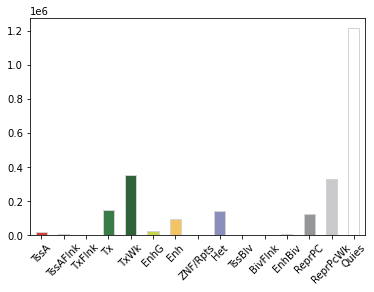

In [345]:
ax0=count_all_renamed.loc[:,"chr1"].plot.bar(rot=45, color=color_dec, edgecolor="lightgray")  # total state

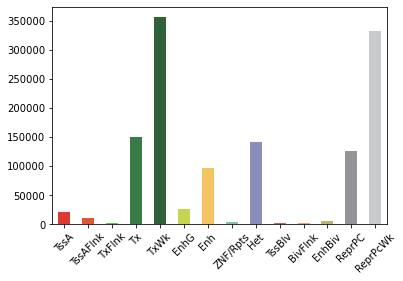

In [342]:
ax1=count_all_renamed.loc[:,"chr1"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

In [350]:
df[df["chromosome"]=="chrM"]

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
615812,chrM,0,12600,15,12600,126,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
615813,chrM,12600,12800,9,200,2,I,II
615814,chrM,12800,13000,8,200,2,H,HH
615815,chrM,13000,16400,5,3400,34,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE


#### Test starts from here

In [133]:
df_asis=bed2df_as_is(test_filename)
df_asis.head()

,chromosome,start,end,state
0,chr1,0,9800,15
1,chr1,9800,10800,9
2,chr1,10800,13000,15
3,chr1,13000,13200,7
4,chr1,13200,16000,5


In [134]:
df=bed2df_expanded(test_filename)
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10800,9,1000,10,I,IIIIIIIIII
2,chr1,10800,13000,15,2200,22,O,OOOOOOOOOOOOOOOOOOOOOO
3,chr1,13000,13200,7,200,2,G,GG
4,chr1,13200,16000,5,2800,28,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEE


In [135]:
numchr(df)

25

In [136]:
total_df_list=total_df_maker(all_files)

In [138]:
total_df_list[0].head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [140]:
total_df_list[126].head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,54000,15,54000,540,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,54000,56200,14,2200,22,N,NNNNNNNNNNNNNNNNNNNNNN
2,chr1,56200,84000,15,27800,278,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,84000,88800,14,4800,48,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
4,chr1,88800,235400,15,146600,1466,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [142]:
df_all_css=df2css_allchr(df)

# check first 10 characters of the string
df_all_css[:10] 

'OOOOOOOOOO'

In [246]:
df.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
635728,chrY,58891400,58968400,15,77000,770,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
635729,chrY,58968400,58970200,9,1800,18,I,IIIIIIIIIIIIIIIIII
635730,chrY,58970200,58971200,15,1000,10,O,OOOOOOOOOO
635731,chrY,58971200,59033400,9,62200,622,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
635732,chrY,59033400,59373400,15,340000,3400,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [ ]:
# To collect the number of sequences for each chromosome, scan the start column
total_row=len(df)
chr_len=[]
chr_check=[]
chr_index=[]

for i in range(total_row):
    if (df["start"].iloc[i]==0) & (i >0):
        chr_len.append(df["end"].iloc[i-1])
        chr_check.append(df["start"].iloc[i]) # assert
        chr_index.append(i-1)


end_len=df["end"].iloc[-1]
end_index=total_row-1

chr_len.append(end_len)
chr_index.append(end_index)

assert len(chr_len)==df["chromosome"].nunique()
assert len(chr_index)==df["chromosome"].nunique()

### class test ...should I make a class?

In [74]:
class bed2df_cls:
    
    def __init__(self, fname):
        
        self.fname=fname
        
        df_raw=pd.read_csv(fname, sep='\t', lineterminator='\n', 
                           header=None, low_memory=False)
        df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
        df=df[:-1] # remove the end row: it displayed the cell id and track no.
        df["start"]=pd.to_numeric(df["start"])
        df["end"]=pd.to_numeric(df["end"])
        df["length"]=df["end"]-df["start"]
        df["unit"]=(df["length"]/100).astype(int)
        
        state_dict={1:"A", 2:"B", 3:"C", 4:"D", 5:"E",6:"F",7:"G",8:"H" ,
                    9:"I" ,10:"J",11:"K", 12:"L", 13:"M", 14:"N", 15:"O"}
        
        df["state"]=pd.to_numeric(df["state"])
        df["state_seq"]=df["state"].map(state_dict)
        df["state_seq_full"]=df["unit"]*df["state_seq"]
        
        self.df=df
        self.df_len=len(df)
        self.numchr=df["chromosome"].nunique()
        
        print(".df : dataframe \n.df_len : length of dataframe \n.numchr : no. of chromosome")
        
     

In [76]:
df_test=bed2df_cls(filename)
df_test.df.head()

.df : dataframe 
.df_len : length of dataframe 
.numchr : no. of chromosome


,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10800,9,1000,10,I,IIIIIIIIII
2,chr1,10800,13000,15,2200,22,O,OOOOOOOOOOOOOOOOOOOOOO
3,chr1,13000,13200,7,200,2,G,GG
4,chr1,13200,16000,5,2800,28,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEE
